In [1]:
import numpy as np
import scipy
import torch

import sigkernel

from tqdm.notebook import trange
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

import warnings
warnings.filterwarnings('ignore')

In [2]:
def exp_kernel(x, y, sigma):
    return np.exp(-(x-y)**2/(2.*sigma**2))

def K(t, s, H):
    return np.sqrt(2.*H)*(t-s)**(H-0.5)

In [3]:
def generator(n_samples=100, T=1., dt=0.01, H=0.1, x0=100., v0=0.055, nu=1.9, rho=-0.9, random_state=None):

    # set random state
    np.random.seed(random_state)

    # number of time steps
    n_steps = int(T/dt)
    
    # random time indices
    t_indices = np.random.choice(np.arange(n_steps), n_samples)

    # initialize arrays
    t_samples = torch.zeros((n_samples,))
    x_samples = torch.zeros((n_samples,))
    V_samples = torch.zeros((n_samples, n_steps))
    X_samples = torch.zeros((n_samples, n_steps))
    K_samples = torch.zeros((n_samples, n_steps))
    Theta_samples = torch.zeros((n_samples, n_steps))

    # nu^2/2
    nu_ = (nu**2)/2

    # Generate sample paths
    for i in trange(n_samples):
        
        # Brownian increments
        dw1 = np.random.normal(size=n_steps-1, scale=np.sqrt(dt))
        dw2 = np.random.normal(size=n_steps-1, scale=np.sqrt(dt))
        db = rho*dw1 + np.sqrt(1.-rho**2)*dw2

        # Variance process V
        for j in range(1, n_steps):
            t = j*dt
            K1, K2 = 0., 0.
            for k in range(j):
                s = k*dt
                K1 += K(t,s,H)*dw1[k]
                K2 += (K(t,s,H)**2)*dt
            V_samples[i,j] = v0*np.exp(nu*K1 - nu_*K2)
            
        # log-price process X
        X_samples[i,0] = x0
        X_samples[i,1:] = x0 + np.cumsum(np.sqrt(V_samples[i,1:])*db) - .5*np.cumsum(V_samples[i,1:]*dt)
            
        # cut-off point t0
        i0 = t_indices[i]
        t0 = i0*dt
        
        # time samples
        t_samples[i] = t0
        
        # price samples
        x_samples[i] = X_samples[i, i0]
        
        # process Theta 
        for j in range(i0, n_steps):
            t = j*dt
            K1, K2 = 0., 0.
            for k in range(i0):
                s = k*dt
                K1 += K(t,s,H)*dw1[k]
                K2 += (K(t,s,H)**2)*dt
            Theta_samples[i,j] = nu*K1 - nu_*K2
            
        # directional derivatives 
        for j in range(i0+1, n_steps):
            t = j*dt
            K_samples[i, j] = K(t, t0, H)
    
    # add second zero coordinate to paths K
    K_samples = K_samples.unsqueeze(-1)
    zeros = torch.zeros_like(K_samples)
    K_samples = torch.cat([zeros, K_samples], dim=-1)
    
    # add time to paths Theta
    Theta_samples = torch.tensor(sigkernel.transform(Theta_samples, at=True), dtype=Theta_samples.dtype)
    
    # add time to paths X
    X_samples = torch.tensor(sigkernel.transform(X_samples, at=True), dtype=X_samples.dtype)

    return t_indices, t_samples, x_samples, K_samples, Theta_samples, X_samples

In [4]:
n_samples, T, dt, H, x0, v0, nu = 100, 0.1, 0.001, 0.1, 100., 0.055, 1.9
t_indices, t_samples, x_samples, K_samples, Theta_samples, X_samples = generator(n_samples, T, dt, H, x0, v0, nu)

  0%|          | 0/100 [00:00<?, ?it/s]

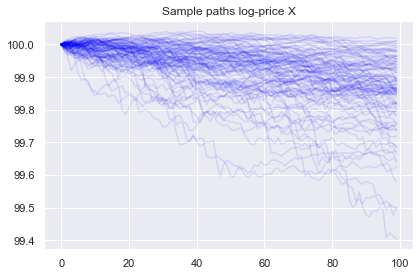

In [5]:
for i in range(n_samples):
    plt.plot(X_samples[i,:,1], c='blue', alpha=0.1)
plt.title('Sample paths log-price X')
plt.tight_layout()
plt.show()

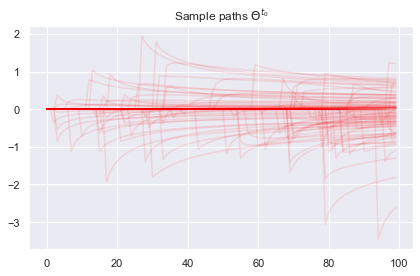

In [6]:
for i in range(n_samples):
    plt.plot(Theta_samples[i,:,1], c='red', alpha=0.1)
plt.title('Sample paths $\Theta^{t_0}$')
plt.tight_layout()
plt.show()

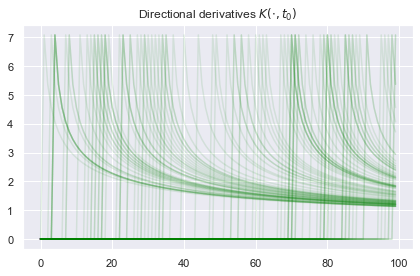

In [7]:
for i in range(n_samples):
    plt.plot(K_samples[i,:,1], c='green', alpha=0.1)
plt.title('Directional derivatives $K(\cdot,t_0)$')
plt.tight_layout()
plt.show()

We are interested in solving the following PDE

\begin{equation}
\left(\partial_t - \frac{\nu^2}{2} \partial_{K(t,\cdot)^2} - \frac{v_0}{2}\exp(\gamma_{t}) \partial_x + \frac{v_0}{2}\exp(\gamma_{t}) \partial_{xx}^2 - \frac{v_0}{2}\exp(\gamma_{t}) \partial_{K(t,\cdot)^2 x}^2 + \frac{1}{2} \partial_{K(t,\cdot)K(t,\cdot)}^2 \right) u(t,x,\gamma) = 0
\end{equation}

with boundary conditions
\begin{equation}
    u(T,x,\gamma) = f(x)
\end{equation}

### 2) RKHS approximation

We use the following RKHS approximation

\begin{align}
 u(t,x,\gamma) &\approx \sum_{i=1}^M \alpha_i\exp\left(-{\frac{(t-t^i)^2}{2 \sigma^2_t}}\right)\exp\left(-{\frac{(x-x^i)^2}{2 \sigma_x^2}}\right)k_{sig}(\gamma,\gamma^i) 
\end{align}


#### Derivatives

\begin{align}
    \partial_t u(t,x,\gamma) \approx \sum_{i=1}^M -\alpha_i\frac{t-t^i}{\sigma_t^2}\exp\left(-{\frac{(t-t^i)^2}{2 \sigma^2}}\right)\exp\left(-{\frac{(x-x^i)^2}{2 \sigma_x^2}}\right)k_{sig}(\gamma,\gamma^i)
\end{align}


\begin{align}
    \partial_x u(t,x,\gamma) \approx \sum_{i=1}^M -\alpha_i\frac{x-x^i}{\sigma_x^2}\exp\left(-{\frac{(t-t^i)^2}{2 \sigma^2}}\right)\exp\left(-{\frac{(x-x^i)^2}{2 \sigma_x^2}}\right)k_{sig}(\gamma,\gamma^i)
\end{align}

\begin{align}
    \partial_{xx}^2 u(t,x,\gamma) \approx \sum_{i=1}^M -\alpha_i\frac{\sigma^2_x - (x-x^i)^2}{\sigma_x^4}\exp\left(-{\frac{(t-t^i)^2}{2 \sigma^2}}\right)\exp\left(-{\frac{(x-x^i)^2}{2 \sigma_x^2}}\right)k_{sig}(\gamma,\gamma^i)
\end{align}

\begin{align}
    \partial_\tau u(t,x,\gamma) \approx \sum_{i=1}^M \alpha_i\exp\left(-{\frac{(t-t^i)^2}{2 \sigma^2_t}}\right)\exp\left(-{\frac{(x-x^i)^2}{2 \sigma_x^2}}\right)\partial_\tau k_{sig}(\gamma,\gamma^i)
\end{align}

\begin{align}
    \partial_{\tau\tau}^2 u(t,x,\gamma) \approx \sum_{i=1}^M \alpha_i\exp\left(-{\frac{(t-t^i)^2}{2 \sigma^2_t}}\right)\exp\left(-{\frac{(x-x^i)^2}{2 \sigma_x^2}}\right)\partial_{\tau\tau}^2 k_{sig}(\gamma,\gamma^i)
\end{align}

\begin{align}
    \partial_{\tau x}^2 u(t,x,\gamma) \approx \sum_{i=1}^M -\alpha_i\frac{x-x^i}{\sigma_x^2}\exp\left(-{\frac{(t-t^i)^2}{2 \sigma^2_t}}\right)\exp\left(-{\frac{(x-x^i)^2}{2 \sigma_x^2}}\right)\partial_{\tau} k_{sig}(\gamma,\gamma^i)
\end{align}

### 3) Gradient descent optimisation

We solve the following optimisation by gradient descent

\begin{align}
    \min_{\mathbf{\alpha} = \{\alpha_1,...,\alpha_M\}} \Big\{ \lambda\mathcal{L}_1(\mathbf{\alpha}) + (1-\lambda)\mathcal{L}_2(\mathbf{\alpha})\Big\}
\end{align}

where 

\begin{align}
    \mathcal{L}_1(\mathbf{\alpha}) = \mathbb{E}_{(t,x,\gamma) \sim \mathbb{P}_{t,x,\gamma}}\Big[\Big\{\sum_{i=1}^M \alpha_i &\Big[ \Big(-\frac{t-t^i}{\sigma_t^2} + \Big(\frac{x-x^i}{\sigma_x^2} - \frac{\sigma_x^2 - (x-x^i)^2}{\sigma_x^4} \Big)\frac{v_0}{2}\exp(\gamma_{t}) \Big)k_{sig}(\gamma,\gamma^i)\\
    & + \Big(-\frac{\nu^2}{2} + \frac{v_0}{2}\exp(\gamma_{t})\frac{x-x^i}{\sigma_x^2}\Big)\partial_{K(t,\cdot)^2}k_{sig}(\gamma,\gamma^i)\\
    &+ \frac{1}{2}\partial^2_{K(t,\cdot)K(t,\cdot)}k_{sig}(\gamma,\gamma^i)\Big]\exp\Big(-{\frac{(t-t^i)^2}{2 \sigma^2_t}}\Big)\exp\Big(-{\frac{(x-x^i)^2}{2 \sigma_x^2}}\Big)\Big\}^2\Big]
\end{align}

and 

\begin{equation}
    \mathcal{L}_2(\mathbf{\alpha}) = \mathbb{E}_{x \sim \mathbb{P}_x}\Big[\Big(\sum_{i=1}^M \alpha_i\exp\left(-{\frac{(T-t^i)^2}{2 \sigma^2_t}}\right)\exp\left(-{\frac{(x-x^i)^2}{2 \sigma_x^2}}\right) - f(x)\Big)^2 \Big]
\end{equation}

In [8]:
def L1(alphas, n_samples, sk, t_cps, x_cps, Theta_cps, sigma_t, sigma_x, sigma_sig, x0, v0, nu):
    
    # nb of collocation points
    n_cps = alphas.shape[0]
    
    # generate samples
    t_ind_batch, t_batch, x_batch, K_batch, Theta_batch, _ = generator(n_samples, T, dt, H, x0, v0, nu)
        
    losses = []
    for j in range(n_samples):
        
        # select sampled index, time and log-price
        ind = t_ind_batch[j]
        t = t_batch[j]
        x = x_batch[j]
        
        loss = 0.
        for i in range(n_cps):
            
            # select collocation points
            ti = t_cps[i]
            xi = x_cps[i]
            gi = Theta_cps[i,...].unsqueeze(0)
            
            # select sampled path
            g = Theta_batch[j,...].unsqueeze(0)
            
            # select sampled directional derivative
            k_diff = K_batch[j,...].unsqueeze(0)
            k_diff2 = k_diff**2
            
            # compute directional derivative of sigkernel(g,gi) along k_diff2
            ksig, ksig_diff, _ = sk.compute_kernel_and_derivative(g, gi, k_diff2, max_batch)
            
            # compute second directional derivative of sigkernel(g,gi) along k_diff
            ksig, _, ksig_diffdiff = sk.compute_kernel_and_derivative(g, gi, k_diff, max_batch)

            # first term of loss
            l11 = (t-ti)/(sigma_t**2) 
            l12 = (x-xi)/(sigma_x**2) 
            l13 = (sigma_x**2 - (x-xi)**2)/(sigma_x**4)
            l14 = .5*v0*np.exp(Theta_batch[k,ind,1])
            l1 = (-l11 + (l12-l13)*l14)*ksig[0]
            
            # second term of loss
            l2 = (.5*nu**2 + l12*l14)*ksig_diff[0]
            
            # third term of loss
            l3 = .5*ksig_diffdiff[0]
            
            # putting everything together
            fac1 = exp_kernel(t, ti, sigma_t)
            fac2 = exp_kernel(x, xi, sigma_x)
            loss += alphas[i]*(a1+a2+a3)*fac1*fac2
        losses.append(loss**2)
    return torch.mean(losses)

def L2(alphas, n_samples, t_cps, x_cps, sigma_t, sigma_x, T, x0, v0, nu, f):
    
    # nb of collocation points
    n_cps = alphas.shape[0]
    
    # generate samples
    _, _, x_batch, _, _, _ = generator(n_samples, T, dt, H, x0, v0, nu)
    
    losses = []
    for j in range(n_samples):
        x = x_batch[j]
        loss = 0.
        for i in range(n_cps):
            fac1 = exp_kernel(T, t_cps[i], sigma_t)
            fac2 = exp_kernel(x, x_cps[i], sigma_x)
            loss += alphas[i]*fac1*fac2
        losses.append((loss-f(x))**2)
    return torch.mean(losses)

def L(alphas, n_samples, sk, t_cps, x_cps, Theta_cps, sigma_t, sigma_x, sigma_sig, T, x0, v0, nu, f, lambda_=.5):
    
    l1 = L1(alphas, n_samples, sk, t_cps, x_cps, Theta_cps, sigma_t, sigma_x, sigma_sig, x0, v0, nu)
    l2 = L2(alphas, n_samples, t_cps, x_cps, sigma_t, sigma_x, T, x0, v0, nu, f)
    
    return lambda_*l1 + (1.-lambda_)*l2

def evaluate(alphas, sk, t_batch, x_batch, Theta_batch, t_cps, x_cps, Theta_cps, sigma_t, sigma_x, sigma_sig):
    n_cps = alphas.shape[0]
    n_samples = t_batch.shape[0]
    out = torch.zeros((n_samples,))
    for j in range(n_samples):
        for i in range(n_cps):
            fac1 = exp_kernel(t_batch[j], t_cps[i], sigma_t)
            fac2 = exp_kernel(x_batch[j], x_cps[i], sigma_x)
            fac3 = sk.compute_kernel(Theta_batch[j].unsqueeze(0), Theta_cps[i].unsqueeze(0))[0]
            out[j] = out[j] + alphas[i]*fac1*fac2*fac3
    return out

In [9]:
# boundary condition
strike = 100.
f = lambda x: max(x - strike, 0.)

# collocation points
n_cps = 10
_, t_cps, x_cps, _, Theta_cps, _ = generator(n_cps, T, dt, H, x0, v0, nu)

# kernel hyperparameters
sigma_t, sigma_x, sigma_sig = 1., 1., 1.

# Specify the static kernel 
static_kernel = sigkernel.RBFKernel(sigma=sigma_sig)

# Specify dyadic order and maximum batch size for PDE solver
dyadic_order, max_batch = 1, 100

# Initialize the corresponding signature kernel
sk = sigkernel.SigKernel(static_kernel, dyadic_order)

# randomly initialize the trainable parameters
alphas = torch.tensor(np.random.normal(size=n_cps, scale=np.sqrt(1./n_cps)), requires_grad=True)

# gradient descent parameters
step_size = 0.1
n_iter    = 20
n_samples = 50
lambda_   = .5

# training by gradient descent
losses = []
for i in range(n_iter):
    
    # computing loss
    loss = L(alphas, n_samples, sk, t_cps, x_cps, Theta_cps, sigma_t, sigma_x, sigma_sig, T, x0, v0, nu, f, lambda_) 
    
    # storing the calculated loss
    losses.append(loss.item())
    
    # backward pass for computing the gradients of the loss w.r.t to learnable parameters
    loss.backward()
    
    # updateing the parameters after each iteration
    alphas.data = alphas.data - step_size * alphas.grad.data
    
    # zeroing gradients after each iteration
    alphas.grad.data.zero_()
    
    # priting the values for understanding
    print('{}, \t{}, \t{}'.format(i, loss.item(), alphas.item()))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

NameError: name 'sig_kernel_derivative_batch' is not defined